In [1]:
import torch
import matplotlib.pyplot as plt
from functions import *

# INITIALIZATION

In [2]:
Nb = 1e6                        #Number of bits on transmission
Eb = 9                          #Average energy of the bit
M = 4                           #4-PAM modulation
n = 2                           #Antenna array NxN
SNRmin = 0                      #Minimum SNR [dB]
SNRmax = 24                     #Maximun SNR [dB]
SNRstep = 1                     #Step for SNR array[dB]
k = torch.log2(torch.tensor(M)) #Number of bits on each symbol
Ns = int(torch.floor(Nb/k))     #Number of symbols (multiple of k)
Nb = int(Ns*k)                  #Number of bits on transmission (multiple of k)
Es = k*Eb                       #Symbol energy
verbose = 1                     #Progress indicator

#Data generation as one sequence
#We are supposing a multi-user transmission
bn = torch.randint(0,2,(1,Nb*n))

# M-PAM TRANSMITTER

In [3]:
[Xn,Bn,An,phi,alphabet] = t_transmisorpamV2(bn,Eb,M,torch.ones(1),1)

#Data reshape. Each row represents an antenna
Xn = Xn.reshape(n,Ns)
An = An.reshape(n,Ns) 
Bn = Bn.reshape(n,Nb) 

# CHANNEL

In [4]:
H = torch.eye(n)          #Channel matrix
#H = torch.tensor(((1, 0.45),(0.25, 1)))
#H = torch.tensor(((1, 0.2),(1, 0.25)))

Hinv = torch.linalg.inv(H)

SNRdb = torch.arange(SNRmin,SNRmax,SNRstep) #SNR values

# TRANSMISION AND DETECTION

In [5]:
berZF= torch.empty(n,0)
berLMMSE = torch.empty(n,0)
berML= torch.empty(n,0)

#Possible alphabet combinations at reception
x = alphabet[t_de2Nary(torch.arange(M**n),n,len(alphabet)) ]

if verbose: print('Simulating SNR = ', end = '')
for ii in range(len(SNRdb)):
    if verbose: print('{}, '.format(SNRdb[ii]), end = '')
    
    SNR = 10**(SNRdb[ii]/10)          #Signal to Noise Ratio [n.u.]
    varzn = Eb/(2*SNR)                              #Noise variance
    Wn = torch.sqrt(varzn)*torch.randn(*Xn.shape)  #AWGN
    
    Rn = H@Xn + Wn  #Channel output
    
    # ZERO FORCING (ZF)
    Z = Hinv@Rn
    
    Andetected = t_detectaSBF(Z.flatten(),alphabet).reshape(n,Ns) #Detected symbols
    Bndetected = t_simbolobit(Andetected.flatten(),alphabet).reshape(n,Nb) #Detected bits
    errorsBit = Nb-torch.sum(Bndetected==Bn,axis=1) # Nº Errors per bit
    berZF = torch.hstack((berZF,(errorsBit/Nb).reshape(n,1)))

    # LINEAR MINIMUM MEAN SQUARED ERROR (LMMSE)
    Z = torch.linalg.inv(H.T@H + varzn/Es*torch.eye(n))@H.T@Rn
    
    Andetected = t_detectaSBF(Z.flatten(),alphabet).reshape(n,Ns) #Detected symbols
    Bndetected = t_simbolobit(Andetected.flatten(),alphabet).reshape(n,Nb) #Detected bits
    errorsBit = Nb-torch.sum(Bndetected==Bn,axis=1) # Nº Errors per bit
    berLMMSE = torch.hstack((berLMMSE,(errorsBit/Nb).reshape(n,1)))

    # MAXIMUM LIKELIHOOD (ML)
    hx = torch.unsqueeze(H@x,2) #H@x with shape (n,combinations,1)
    Z = x[:,torch.argmin(torch.linalg.norm(Rn.reshape(n,1,Ns)-hx,dim=0),axis=0)]

    Andetected = t_detectaSBF(Z.flatten(),alphabet).reshape(n,Ns) #Detected symbols
    Bndetected = t_simbolobit(Andetected.flatten(),alphabet).reshape(n,Nb) #Detected bits
    errorsBit = Nb-torch.sum(Bndetected==Bn,axis=1) # Nº Errors per bit
    berML = torch.hstack((berML,(errorsBit/Nb).reshape(n,1)))

Simulating SNR = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 

# BER

In [6]:
SNRdb2 = torch.arange(0,SNRmax,step=0.01)   #SNR array for theoretical calculus
SNR2 = 10**(SNRdb2/10)                  #SNR in natural units

print('\n\nCalculating theoretical bit error rate')
serTheo = (2*(M-1)/M)*t_Qfunct(torch.sqrt((6*torch.log2(torch.tensor(M))/(M**2-1))*SNR2))
berTheo = serTheo/torch.log2(torch.tensor(M))

print('Calculating simulated bit error rate')
berZFav    = sum(berZF)/n
berLMMSEav = sum(berLMMSE)/n
berMLav    = sum(berML)/n



Calculating theoretical bit error rate
Calculating simulated bit error rate


# RESULTS


Showing results


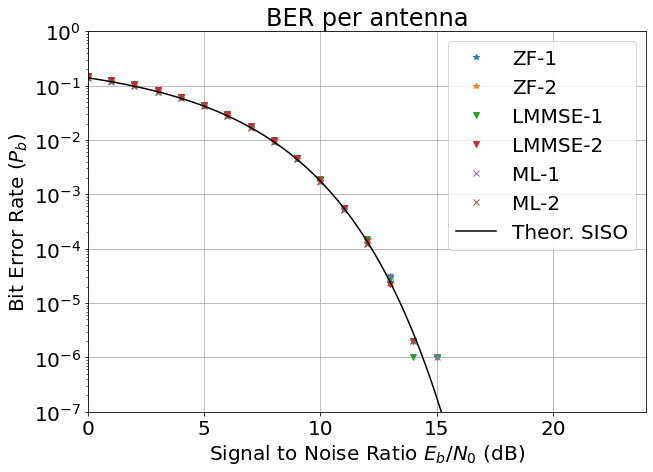

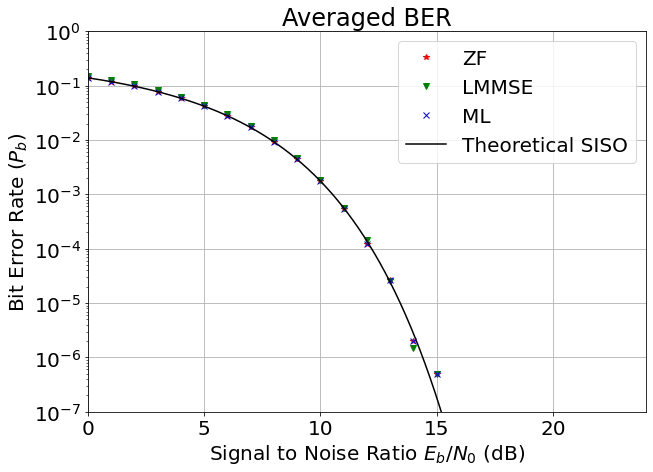

In [7]:
print('\nShowing results')
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

# BER per antenna
plt.figure(1,figsize=(10,7))
legend = ('ZF-1','ZF-2','LMMSE-1','LMMSE-2','ML-1','ML-2','Theor. SISO')
plt.semilogy(SNRdb,berZF.T,'*',SNRdb,berLMMSE.T,'v',SNRdb,berML.T,'x',SNRdb2,berTheo,'-k')
plt.axis([SNRmin,SNRmax,10**-7,1])
plt.grid()
plt.xlabel('Signal to Noise Ratio $E_b/N_0$ (dB)');
plt.ylabel('Bit Error Rate ($P_b$)');
plt.legend(legend)
plt.title('BER per antenna')

plt.show()

# Averaged BER
plt.figure(2,figsize=(10,7))
legend = ('ZF','LMMSE','ML','Theoretical SISO')
plt.semilogy(SNRdb,berZFav,'*r',SNRdb,berLMMSEav,'vg',SNRdb,berMLav,'xb',SNRdb2,berTheo,'-k')
plt.axis([SNRmin,SNRmax,10**-7,1])
plt.grid()
plt.xlabel('Signal to Noise Ratio $E_b/N_0$ (dB)');
plt.ylabel('Bit Error Rate ($P_b$)');
plt.legend(legend)
plt.title('Averaged BER')

plt.show()